## Neural Network Tuning Experiment

In this experiment you will try to tune a neural network to achieve optimal performance on a classification task.

Note that we have selected the GPU runtime in `Runtime > Change runtime type` to speed up neural network training.

In [1]:
import keras
from keras import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, f1_score
from matplotlib import pyplot as plt

We will use the the ["covertype" dataset](https://archive.ics.uci.edu/dataset/31/covertype) from the UCI ML repository.  The task is to predict forest cover type from various cartographic variables, such as elevation, aspect, slope, hillshade, and soil type.  There are seven different forest cover types so it is a multi-class classification problem.

I have prepared a CSV version of the dataset in my Dropbox.

In [2]:
!wget --no-clobber "https://www.dropbox.com/scl/fi/ilu8tsp5ryypdsmsd8rbx/covtype.csv?rlkey=je2sjl1yfqjn4y4mjyjyj71bj&dl=1" -O covtype.csv

--2023-12-01 06:00:08--  https://www.dropbox.com/scl/fi/ilu8tsp5ryypdsmsd8rbx/covtype.csv?rlkey=je2sjl1yfqjn4y4mjyjyj71bj&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc24aa6649678ed187c6022e458f.dl.dropboxusercontent.com/cd/0/inline/CInxIDfPP_-JW4gaAfRXZkpKj_ZR92OXhrksJlttGWUtw4svXavjLRXNtLSJopxOL-eEjZFB92-hcl2JNZU7xGFDgWIfiIMyNJNy4YA1KtK9H4eC83sjf4ufHykqoBcXM9YifwCJz2xflLqaKU8n59PT/file?dl=1# [following]
--2023-12-01 06:00:09--  https://uc24aa6649678ed187c6022e458f.dl.dropboxusercontent.com/cd/0/inline/CInxIDfPP_-JW4gaAfRXZkpKj_ZR92OXhrksJlttGWUtw4svXavjLRXNtLSJopxOL-eEjZFB92-hcl2JNZU7xGFDgWIfiIMyNJNy4YA1KtK9H4eC83sjf4ufHykqoBcXM9YifwCJz2xflLqaKU8n59PT/file?dl=1
Resolving uc24aa6649678ed187c6022e458f.dl.dropboxusercontent.com (uc24aa6649678ed187c6022e458f.dl.dropboxusercontent.com)... 162.12

The data unfortunately does not have column names so I just added integer column names here.

In [3]:
df = pd.read_csv('covtype.csv',names=range(55))

The first 10 variables are numeric, the next 40 are binary (indicating the soil type).  The last column is the forest cover type label (1 to 7).

Here we use a column transformer to apply standard scaling to the numeric variables and leave the rest as-is.

In [4]:
ct = make_column_transformer(
  (StandardScaler(),list(range(10))),
  remainder='passthrough'
)

In [5]:
data = ct.fit_transform(df)

Now we extract the features and target variables, taking care to shift the labels to be zero-indexed.

In [6]:
X = data[:,:-1]
y = data[:,-1]-1

In [7]:
X.shape,y.shape

((581012, 54), (581012,))

Now we prepare a 90/10 train/test split.

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.1,random_state=42)

To speed up our experiments, we will take use only a fraction of the training data to start with.

In [9]:
inds = np.random.choice(range(len(X_train)),len(X_train)//10)
X_train_small = X_train[inds]
y_train_small = y_train[inds]

## Neural network setup

To create a feed-forward neural network using Keras, we can use the Sequential class which accepts a list of layers as its argument.

The `Input` layer specifies the shape of the input, not including the batch dimension (the first dimension).

A `Dense` layer implements the linear transformation optionally combined with a non-linear activation:

$$x' = \sigma(Wx+b)$$

The first argument is the number of hidden units, i.e., the width.  ReLU is the standard choice for activation but there are many others to choose from.

The final layer needs to have an output size of seven, since there are seven possible forest cover types.  We use the Softmax activation to produce class probabilities:

$$P(c_i|x)~\textrm{for}~i \in \{0,\ldots,6\}.$$


In [10]:
model = Sequential([
    Input(X_train.shape[1:]),
    Dense(128,activation='relu'),
    Dense(7,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7040      
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7943 (31.03 KB)
Trainable params: 7943 (31.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now we specify some hyperparameters: the learning rate, batch size, and number of epochs.

In [11]:
learning_rate = 0.01
batch_size = 32
epochs = 3

Before we can train the model we need to select an optimizer and compile the model with a loss function.

As a starting point we use the `SGD` optimizer which implements stochastic gradient descent with momentum.  `Adam` is the modern optimizer of choice, but there are many other optimizers to choose from as well.

We need to use the `sparse_categorical_crossentropy` loss since we have a multi-class classification problem and our labels are stored as integers (rather than one-hot encoded).

We can also tell Keras to compute other metrics to monitor during training such as accuracy.  These are not included in the loss function but only shown to help gauge model performance during training.

In [12]:
opt = SGD(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics='accuracy')

We will add a `ModelCheckpoint` callback which will monitor the validation loss and save the weights of the best model during training.  There are many other callbacks available to do things like adjust the learning rate during training or apply early stopping.


In [13]:
callbacks = [ModelCheckpoint('weights.h5',save_best_only=True,save_weights_only=True)]

In [14]:
history = model.fit(X_train_small,y_train_small,
                    validation_split=0.1,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    verbose=True)

Epoch 1/3
1471/1471 [==============================] - 10s 4ms/step - loss: 0.9404 - accuracy: 0.6440 - val_loss: 0.7846 - val_accuracy: 0.6891
Epoch 2/3
1471/1471 [==============================] - 4s 3ms/step - loss: 0.7396 - accuracy: 0.7026 - val_loss: 0.7095 - val_accuracy: 0.7038
Epoch 3/3
1471/1471 [==============================] - 4s 3ms/step - loss: 0.6891 - accuracy: 0.7133 - val_loss: 0.6732 - val_accuracy: 0.7178


Once training is done we can plot the training and validation loss and accuracy curves, to look for overfitting and underfitting.

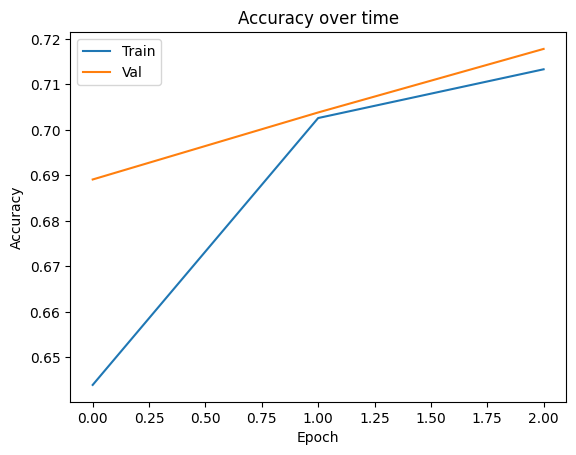

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over time')
plt.legend(['Train','Val'])
plt.show()

After training, we can get model predictions for test set.  

In [16]:
preds = model.predict(X_test)

1816/1816 [==============================] - 4s 2ms/step


The model produces class probabilities, so has a shape of $N\times7$ since there are seven classes.

In [17]:
preds.shape

(58102, 7)

Here are the class probabilities for the first test set instance.

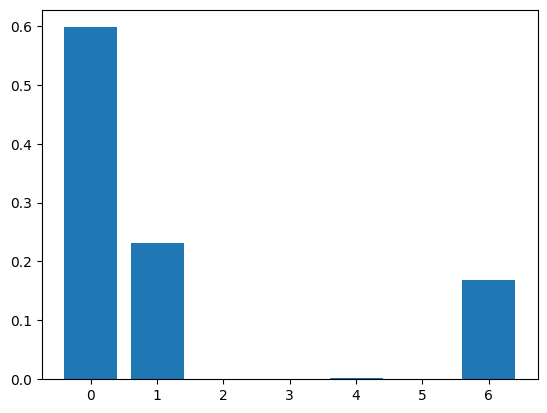

In [18]:
plt.bar(range(7),preds[0])
plt.show()

To get integer predictions we can use `np.argmax` to find the class with highest probability for each instance.

In [19]:
y_pred = np.argmax(preds,axis=-1)

In [20]:
y_pred[:10]

array([0, 1, 1, 1, 1, 2, 1, 0, 0, 1])

Now we can calculate metrics in the normal way with scikit-learn.

In [21]:
test_accuracy = accuracy_score(y_test,y_pred)
test_fscore = f1_score(y_test,y_pred,average='weighted')
print('test accuracy:',test_accuracy)
print('test fscore:',test_fscore)

test accuracy: 0.721093938246532
test fscore: 0.7031782716620288


Explore different neural network configurations, hyperparameter settings, and training set sizes to try to improve your test set performance.

In [25]:
def train_model(learning_rate, batch_size, epochs):
  model = Sequential([
      Input(X_train.shape[1:]),
      Dense(128, activation='relu'),
      Dense(7, activation='softmax')
  ])

  opt = SGD(learning_rate=learning_rate)
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=opt,
                metrics='accuracy')

  callbacks = [ModelCheckpoint('weights.h5', save_best_only=True, save_weights_only=True)]

  history = model.fit(X_train_small, y_train_small,
                      validation_split=0.1,
                      batch_size=batch_size,
                      epochs=epochs,
                      callbacks=callbacks,
                      verbose=True)

  preds = model.predict(X_test)
  y_pred = np.argmax(preds, axis=-1)

  test_accuracy = accuracy_score(y_test, y_pred)
  test_fscore = f1_score(y_test, y_pred, average='weighted')
  print('Test Accuracy:', test_accuracy)
  print('Test F-Score:', test_fscore)

  return test_accuracy, test_fscore

In [27]:
learning_rates = [0.01, 0.05, 0.1]
batch_sizes = [16, 32, 64]
epochs = [3, 5, 10]

best_accuracy = 0
best_fscore = 0
best_hyperparameters = None

for rate in learning_rates:
    for batch_size in batch_sizes:
        for epoch in epochs:
            print(f"Training with learning_rate={rate}, batch_size={batch_size}, epochs={epoch}\n")
            accuracy, fscore = train_model(rate, batch_size, epoch)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_fscore = fscore
                best_hyperparameters = {'learning_rate': rate, 'batch_size': batch_size, 'epochs': epoch}

print("Best Hyperparameters:", best_hyperparameters)
print('Best Test Accuracy:', best_accuracy)
print('Best Test F-Score:', best_fscore)

Training with learning_rate=0.01, batch_size=16, epochs=3

Epoch 1/3
2942/2942 [==============================] - 12s 4ms/step - loss: 0.8488 - accuracy: 0.6772 - val_loss: 0.7175 - val_accuracy: 0.7013
Epoch 2/3
2942/2942 [==============================] - 9s 3ms/step - loss: 0.6810 - accuracy: 0.7163 - val_loss: 0.6556 - val_accuracy: 0.7239
Epoch 3/3
1816/1816 [==============================] - 3s 2ms/step
Test Accuracy: 0.7356029052356201
Test F-Score: 0.72095245341774
Training with learning_rate=0.01, batch_size=16, epochs=5

Epoch 1/5
2942/2942 [==============================] - 10s 3ms/step - loss: 0.8441 - accuracy: 0.6735 - val_loss: 0.7111 - val_accuracy: 0.7038
Epoch 2/5
2942/2942 [==============================] - 9s 3ms/step - loss: 0.6766 - accuracy: 0.7192 - val_loss: 0.6535 - val_accuracy: 0.7247
Epoch 3/5
2942/2942 [==============================] - 10s 3ms/step - loss: 0.6414 - accuracy: 0.7298 - val_loss: 0.6299 - val_accuracy: 0.7361
Epoch 4/5
2942/2942 [===========